In [2]:
import numpy as np
import torch
import torchvision as tv
from torch import nn
import  torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

# Visualizer Function

In [3]:
class_name = ["T-shirt","Trouser","Pullover",
                  "Dress","Coat","Sandal","Shirt",
                  "Sneaker","Bag","Ankle boot"]
def visualizer(data,cols=8,rows=8):
    length = len(data)
    fig , axs = plt.subplots(figsize=(8,9),ncols=cols,nrows=rows)
    for i,ax_row in enumerate(axs):
        for ax in ax_row:
            i = torch.randint(low=0,high=length,size=(1,))
            img , lbl = data[i[0]]
            ax.imshow(img.squeeze(),'gray')
            ax.set_title(class_name[lbl],fontsize=6)
            ax.axis(False)
    plt.show()

# Configs

In [59]:
# Define variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 5
lr = 2e-4
classes = 10
channels = 1
img_size = 28
latent_dim = 100
log_interval = 100

# Load Dataset

In [60]:
train = tv.datasets.FashionMNIST(
    root="../masalan2/data",
    train=True,
    download=False,
    transform=ToTensor()
)
trainLoader = DataLoader(train,batch_size=batch_size,shuffle=True)

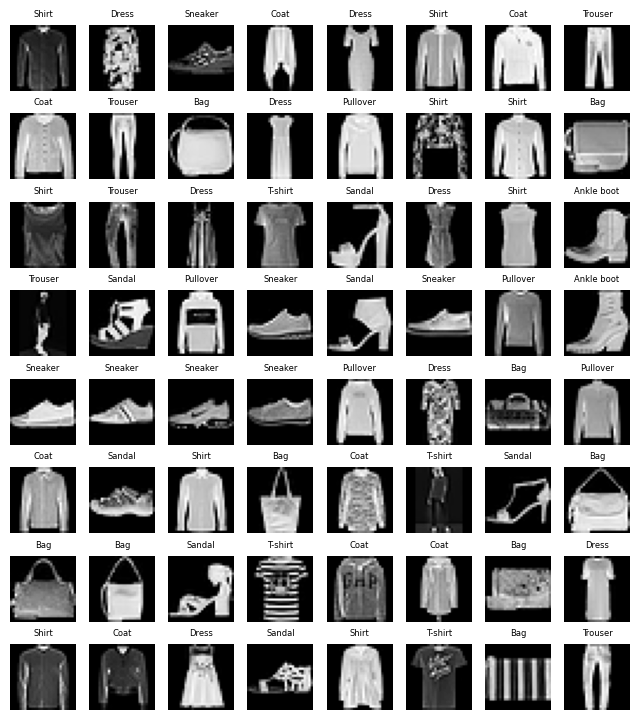

In [6]:
visualizer(train)

In [51]:
class generator(nn.Module):
    def __init__(self):
        super(generator,self).__init__()
        self.img_shape = (channels,img_size,img_size)
        self.label_embedding = nn.Embedding(classes,classes)
        self.model = nn.Sequential(
            *self._layer(latent_dim+classes,128,False),
            *self._layer(128,256),
            *self._layer(256,512),
            *self._layer(512,1024),
            nn.Linear(1024,int(np.prod(self.img_shape))), # 1*28*28
            nn.Tanh()
        )
    def _layer(self,size_in,size_out,normalize=True):
        layers = [nn.Linear(size_in,size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2,inplace=True))
        return layers
    def forward(self,noise,labels):
        z = torch.cat((self.label_embedding(labels),noise),-1)
        x = self.model(z)
        x.view(x.size(0),*self.img_shape)
        return x


In [52]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.img_shape = (channels,img_size,img_size)
        self.label_embedding = nn.Embedding(classes,classes)
        self.adv_loss = nn.BCELoss()
        self.model = nn.Sequential(
            *self._layer(classes+int(np.prod(self.img_shape)),1024,False,True),
            *self._layer(1024,512,True,True),
            *self._layer(512,256,True,True),
            *self._layer(256,128,False,False),
            *self._layer(128,1,False,False),
            nn.Sigmoid()
        )
    def _layer(self,size_in,size_out,drop_out=True,act_func=True):
        layers = [nn.Linear(size_in,size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2,inplace=True))
        return layers
    def forward(self,image,labels):
        x = torch.cat(image.view((image.size(0),-1),self.label_embedding(labels)),-1)
        x = self.model(x)
        return x
    def loss(self,output,label):
        return self.adv_loss(output,label)


In [56]:
gen = generator()
disc = discriminator()
print(gen)
print("="*80)
print(disc)

optG = torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999))
optD = torch.optim.Adam(disc.parameters(),lr=lr,betas=(0.5,0.999))


generator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
discriminator(
  (label_embedding): Embedding(10, 10)
  (adv_loss): BCELoss()
  (model): Sequential(
    (0

# Train

In [ ]:
img_list = []

gen.train() ; disc.train()

for epoch in range(epochs):
    for i , (data,target) in enumerate(trainLoader):
        data , target = data.to(device) , target.to(device)
        real_label = torch.full((batch_size,1),1.,device=device)
        fake_label = torch.full((batch_size,1),0.,device=device)

        # Train Generator
        optG.zero_grad()
        noise = torch.randn(batch_size,latent_dim,device=device)
        x_fake_labels = torch.randint(0,classes,(batch_size,),device=device)
        x_fake = gen(noise , x_fake_labels)
        y_fake_gen = disc(x_fake , x_fake_labels)
        g_loss = disc.loss(y_fake_gen , real_label)
        g_loss = g_loss.backward()
        optG.step()
        